# Evaluating LLMs that grade other LLMs

![Comparing self-evaluation methods](../../../img/evals-llms-multistep-arithmetic.png)

## Introduction

The enormous popularity of LLMs in recent years has spurred research into how to align their outputs with correctness and human intent. Ample examples of hallucinating (more correctly, delusional) outputs are now common fodder for online discussions warning us about the immaturity of LLM technology.

One approach to making LLM outputs logically and factually correct is to do prompt engineering that "guides" them. Chain-of-Thought (CoT) is one such approach. Unfortunately, LLMs are also good at producing entirely reasonably sounding CoT outputs that are, in fact, logically wrong.

The incorrectness of CoT outputs has, in turn, spurred recursive research into checking correctness of LLM outputs - **can we get an LLM to grade the CoT of another LLM?**

Evaluation in unsupervised settings has an "turtles all the way down" problem when it comes to certifying the output of **any** algorithm that claims to evaluate another one. How do we know the checker of the grader is not, itself, flawed? Algebraic evaluation escapes this infinite chain because it merely estimates sample statistics of correctness - it uses algebraic relations between statistics of agreement and disagreement observed counts to limit the evaluations that are logically consistent with them.

This notebook is going to show an early Proof-of-Concept of how algebraic evaluation can be used to grade a panel of LLMs that are judging the CoT output of another, different, LLM. Before these early, initial results are explained some general caveats.

1. The purpose of these experiments is not to compare the three different LLMs with each other after one has taken great care to tune them to their maximum possible accuracy. Very little prompt engineering or parameter tuning (temperature, etc) was done. The goal was to see how easy it was for a relative newbie to use **three** different commercial LLMs and get them to be error-independent on a CoT benchmark.
2. The computations shown here were done with a pre-v0.3 release of the package (currently at v0.2).

## Experimental set-up

### Benchmark

The experimental benchmark used is the multistep-arithmetic collection from the BIG-Bench-Mistake dataset. These are arithmetic problems like the following,
$$1((-1 + 7 + 7 + 9) * (-3 * -1 * 3 * 4)) = \, ?$$
And the CoT-trace for the PaLM 2 response to this query is given as,

> Thought 1: This equation can be written as "(A * B)", where A = (-1 + 7 + 7 + 9) and B = (-3 * -1 * 3 * 4).  
Thought 2: Let's calculate A = (-1 + 7 + 7 + 9) = (22).  
Thought 3: Let's calculate B = (-3 * -1 * 3 * 4) = ((-3 * -1) * (3 * 4)) = (3 * 12) = (36).  
Thought 4: Then, the final equation is (A * B) = (22 * 36) = 792. So the answer is 792.

Which happens to be a correct answer and a CoT free of reasoning errors. But these are a small portion of the dataset since its goal is to spur research into finding and correcting reasoning errors. For the evaluation carried out here, the 300 problems in the multistep-arithmetic benchmark were pared to 281 by eliminating the subset of Cot-style traces that either had incorrect reasoning but correct answers or correct reasoning but incorrect answers.

### LLMs

Many problems in AI safety and alignment would be much simpler if we could just know how well we are doing on average. The approach taken here to solve this problem is to create **error-independent** panels of experts. This means that during a test the experts made errors independently of each other.

There are various engineering designs you can use to encourage error-independence when you have panels of experts. Three easy ones are,

1. Train them on different data.
2. Train them on different features.
3. Use different learning algorithms.

The one we used here is much simpler than this and is more "off-the-shelf" - use LLMs from different commercial vendors. We would expect different companies to do all 3 things in the list above for us. This is born out by an evaluation we carried out were three LLMs,

- Gemini Pro
- Mistral Large
- GPT-4-Turbo

checked the output PaLM 2 CoT traces in the 282 multistep-arithmetic benchmark. Let's walk through that evaluation now.

## Comparing algebraic evaluation with majority voting

In [1]:
# Some imports we need with the ntqr package
import sympy
sympy.init_session()

IPython console for SymPy 1.12 (Python 3.11.5-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
# We will be comparing two algebraic methods, ntqr and majority voting, with the ground truth
# The ground truth is given by the ntqr.r2.evaluators.SupervisedEvaluation class.
import ntqr
from ntqr.r2.evaluators import SupervisedEvaluation
# If we assume binary classifiers are making error independent during a test, we can
# use the exact, algebraic solution detailed in ntqr.r2.evaluators.ErrorIndependentEvaluation
from ntqr.r2.evaluators import ErrorIndependentEvaluation
# And finally, we import the class that does majority voting evaluations
from ntqr.r2.evaluators import MajorityVotingEvaluation

In [3]:
# Using the three LLMs above, we asked them to tell us if the PaLM 2 CoT-traces were wrong.
# - the 'a' label means 'Yes'
# - the 'b' label means 'No'
data_sketch = {
    "a": {
        ("b", "b", "a"): 169,
        ("b", "a", "a"): 24,
        ("a", "b", "b"): 3,
        ("b", "b", "b"): 23,
        ("a", "b", "a"): 16,
        ("a", "a", "a"): 2,
    },
    "b": {
        ("b", "b", "b"): 17,
        ("b", "b", "a"): 20,
        ("b", "a", "b"): 1,
        ("a", "b", "b"): 3,
        ("a", "b", "a"): 3,
    },
}

In [4]:
# Let's do the supervised evaluation (ground truth) for this experiment
from pprint import pp
s_eval = SupervisedEvaluation(ntqr.r2.datasketches.TrioLabelVoteCounts(data_sketch))
pp(s_eval.evaluation_exact)

{'prevalence': {'a': 237/281, 'b': 44/281},
 'accuracy': [{'a': 7/79, 'b': 19/22},
              {'a': 26/237, 'b': 43/44},
              {'a': 211/237, 'b': 21/44}],
 'pair_correlation': {(0, 1): {'a': -8/6241, 'b': -3/968},
                      (0, 2): {'a': -55/18723, 'b': -3/968},
                      (1, 2): {'a': 676/56169, 'b': -23/1936}},
 '3_way_correlation': {(0, 1, 2): {'a': 806/4437351, 'b': -9/5324}}}


It is a little bit hard to rank fractions so let's turn these exact ground truth values to floats.

In [5]:
pp(s_eval.evaluation_float)

{'prevalence': {'a': 0.8434163701067615, 'b': 0.15658362989323843},
 'accuracy': [{'a': 0.08860759493670886, 'b': 0.8636363636363636},
              {'a': 0.10970464135021098, 'b': 0.9772727272727273},
              {'a': 0.890295358649789, 'b': 0.4772727272727273}],
 'pair_correlation': {(0, 1): {'a': -0.0012818458580355712,
                               'b': -0.0030991735537190084},
                      (0, 2): {'a': -0.002937563424664851,
                               'b': -0.0030991735537190084},
                      (1, 2): {'a': 0.012035108333778419,
                               'b': -0.011880165289256199}}}


There are a some things to note:

1. Two the LLMs are doing a bad job on one of the labels - recognizing that the PaLM CoT was wrong. That is the 'a' label and Gemini Pro and Mistral are not recognizing the PaLM 2 mistakes.
2. But GPT-4-Turbo, which does well on finding the wrong Cot-traces, does badly on the correct ones.
3. And finally, success! We set out to create a test where the experts were uncorrelated. And by using different LLM vendors, we were able to do it.

Now comes the interesting part of the experiment - **does having error indendent, or nearly error independent, LLMs help us in evaluating them in an unsupervised setting?**

In [6]:
# In a unsupervised setting, we don't get to see the voting counts by true label
# so we need to 'project' the ground truth to what we would observe
voting_counts = ntqr.r2.datasketches.TrioLabelVoteCounts(data_sketch).to_TrioVoteCounts()
pp(voting_counts)

TrioVoteCounts(vote_counts={('a', 'a', 'a'): 2,
                            ('a', 'a', 'b'): 0,
                            ('a', 'b', 'a'): 19,
                            ('a', 'b', 'b'): 6,
                            ('b', 'a', 'a'): 24,
                            ('b', 'a', 'b'): 1,
                            ('b', 'b', 'a'): 189,
                            ('b', 'b', 'b'): 40})


In [7]:
# We can now calculate the error-independent evaluations and the majority voting one.
ae_eval = ErrorIndependentEvaluation(voting_counts)
mv_eval = MajorityVotingEvaluation(voting_counts)

In [8]:
# Let's compare the prevalence estimates. Remember that most of the
# PaLM CoT-traces are wrong - the 'a' label has a prevalence of 84.3%
# on the test
print("The two solutions from the erro-independent model:")
pp([sol["prevalence"]["a"] for sol in ae_eval.evaluation_float])
print("The two solutions from the majority voting evaluation - majority is always right or always wrong")
pp([sol["prevalence"]["a"] for sol in mv_eval.evaluation_float])

The two solutions from the erro-independent model:
[0.22374136668648772, 0.7762586333135123]
The two solutions from the majority voting evaluation - majority is always right or always wrong
[0.1601423487544484, 0.8398576512455516]


So the 'a' label prevalence is estimated to be 84.0% by MV, a value very close to the true value of 84.3%. The error-independent estimate is off at 77.6%. How about the label accuracies for the three grading LLMs?

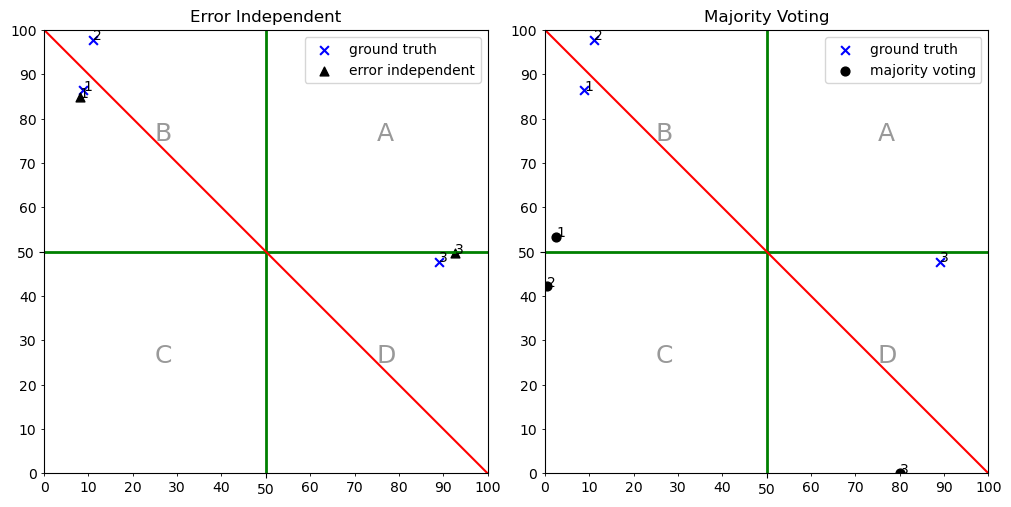

In [9]:
%matplotlib inline
from ntqr.r2.plots import compare_evaluations, plot_evaluations

size=40
seval_exact = s_eval.evaluation_exact
ae_eval_exact = ae_eval.evaluation_exact
mv_eval_exact = mv_eval.evaluation_exact

# We know to pick the 2nd solution as the one closest
# to ground truth
sol = 1
compare_evaluations([
    ["ground truth", 
     [d['a']*100 for d in seval_exact["accuracy"]],
     [d['b']*100 for d in seval_exact["accuracy"]],
      "x","b",size],
    ["error independent",
     [d['a']*100 for d in ae_eval_exact[sol]["accuracy"]],
     [d['b']*100 for d in ae_eval_exact[sol]["accuracy"]],
      "^", "k",size],
    ["majority voting",
     [d['a']*100 for d in mv_eval_exact[sol]["accuracy"]],
     [d['b']*100 for d in mv_eval_exact[sol]["accuracy"]],
      "o", "k",size],],0,
    titles=["Ground Truth","Error Independent", "Majority Voting"],figsize=(10,5),legend_loc="best",withArrows=False)

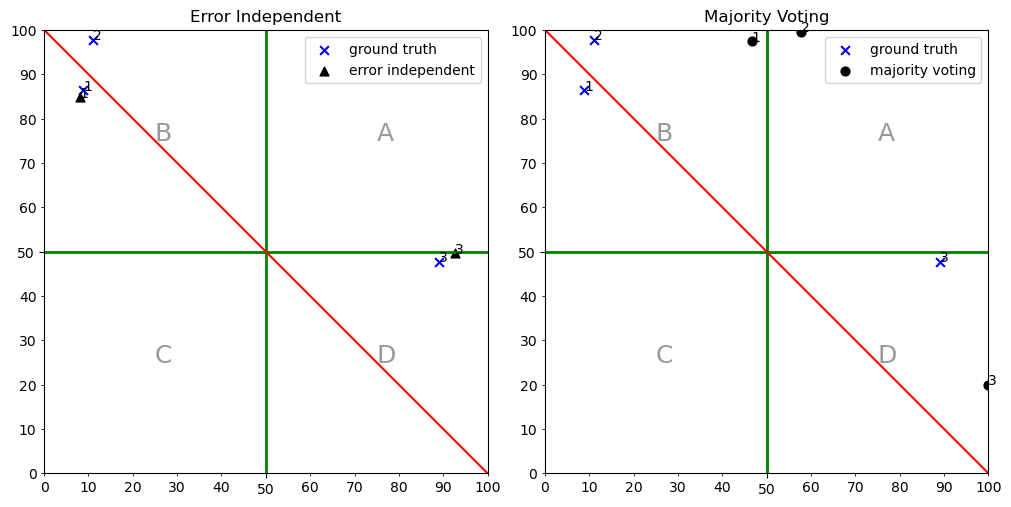

In [10]:
%matplotlib inline
from ntqr.r2.plots import compare_evaluations, plot_evaluations

size=40
seval_exact = s_eval.evaluation_exact
ae_eval_exact = ae_eval.evaluation_exact
mv_eval_exact = mv_eval.evaluation_exact

# We know to pick the 2nd solution as the one closest
# to ground truth
sol = 1
compare_evaluations([
    ["ground truth", 
     [d['a']*100 for d in seval_exact["accuracy"]],
     [d['b']*100 for d in seval_exact["accuracy"]],
      "x","b",size],
    ["error independent",
     [d['a']*100 for d in ae_eval_exact[sol]["accuracy"]],
     [d['b']*100 for d in ae_eval_exact[sol]["accuracy"]],
      "^", "k",size],
    ["majority voting",
     [d['a']*100 for d in mv_eval_exact[0]["accuracy"]],
     [d['b']*100 for d in mv_eval_exact[0]["accuracy"]],
      "o", "k",size],],0,
    titles=["Ground Truth","Error Independent", "Majority Voting"],figsize=(10,5),legend_loc="best",withArrows=False)

The error-independent seems to be very good for classifiers 1 and 3. But what happened to the estimate for classifier 2? Let's check.

In [11]:
# Looking at the error-independent evaluation results
["error independent",
     [float(d['a'])*100 for d in ae_eval_exact[sol]["accuracy"]],
     [float(d['b'])*100 for d in ae_eval_exact[sol]["accuracy"]]]

['error independent',
 [8.00451496620146, 13.40896693859222, 92.76370786462849],
 [84.8263773143796, 103.57683264602629, 49.64993540953866]]

So the error-independent solution thinks the 2nd classifier has a greater than 100% accuracy (103.6%) on label 'b'!

## The beauty of knowing you are wrong

It may sound strange but the failure above by the error-independent model is actually a 'feature' not a 'bug'. It goes back to the type of numbers that are returned by `ntqr.r2.MajorityVotingEvaluation` and `ntqr.r2.ErrorIndependentEvaluation`. Majority voting will always return rational number estimates. But the error indendent solution may not. In the example we are looking at here, it returns irrational algebraic numbers.

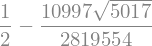

In [12]:
# The algebraic solution from the error-independent evaluation
ae_eval_exact[0]["prevalence"]["a"]

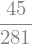

In [13]:
# Majority voting never returns anything but rationals
mv_eval_exact[0]["prevalence"]["a"]

Not only is Majority Voting always going to return rational estimates, it will also return estimates logically consistent with the observed responses from the classifiers. We can check this by looking to see if the Majority Voting estimates satisfy the single classifier axioms.
### Majority voting always gives logically consistent estimates

In [14]:
# Let's import the single binary classifier axiom
from ntqr.r2.paxioms import single_binary_classifier_axiom, pa, pb, pia, pib, fai, fbi
single_binary_classifier_axiom

In [15]:
# Let's check that the axiom is identically zero with the Majority Voting solution
# for all three classifiers
sol = mv_eval_exact[0]
for classifier in range(3):
    vals = {pa: sol["prevalence"]["a"], pb: sol["prevalence"]["b"],
            pia: sol["accuracy"][classifier]["a"], pib: sol["accuracy"][classifier]["b"],
            fai: voting_counts.classifier_label_frequency(classifier,"a"),
            fbi: voting_counts.classifier_label_frequency(classifier,"b"),}
    pp("classifier {}: {}".format(classifier, single_binary_classifier_axiom.subs(vals)))

'classifier 0: 0'
'classifier 1: 0'
'classifier 2: 0'


In [16]:
# The second MV solution is when we assume the majority is always wrong
sol = mv_eval_exact[1]
for classifier in range(3):
    vals = {pa: sol["prevalence"]["a"], pb: sol["prevalence"]["b"],
            pia: sol["accuracy"][classifier]["a"], pib: sol["accuracy"][classifier]["b"],
            fai: voting_counts.classifier_label_frequency(classifier,"a"),
            fbi: voting_counts.classifier_label_frequency(classifier,"b"),}
    pp("classifier {}: {}".format(classifier, single_binary_classifier_axiom.subs(vals)))

'classifier 0: 0'
'classifier 1: 0'
'classifier 2: 0'


So there is nothing we can do to improve the majority voting solution in an unsupervised setting. It always returns rational estimates and they are always logically consistent with the observed disagreements and agreements between the classifiers.

The estimates returned by `ntqr.r2.ErrorIndependentEvaluation` are not like that. They actually signal that its estimates cannot possibly be right as evidenced by those pesky unresolved square root factors in the estimates. Not only that, these estimates are also logically inconsistent with the observed responses by the classifiers. Let's check that with the single binary classifier axiom as we did above for Majority Voting.

### ntqr.ErrorIndependentEvaluation can yield logically inconsistent estimates

In [17]:
# The strength of the ErrorIndependent evaluation is that it can detect
# its assumption - the classifiers are error-independent in the test -
# is violated. We can see this in the unresolved square root
# and that the returned estimates do not obey the single binary classifier
# axiom
sol = ae_eval_exact[1]
for classifier in range(3):
    vals = {pa: sol["prevalence"]["a"], pb: sol["prevalence"]["b"],
            pia: sol["accuracy"][classifier]["a"], pib: sol["accuracy"][classifier]["b"],
            fai: voting_counts.classifier_label_frequency(classifier,"a"),
            fbi: voting_counts.classifier_label_frequency(classifier,"b"),}
    pp("classifier {}: {}".format(classifier, float(single_binary_classifier_axiom.subs(vals))))

'classifier 0: 1.8465957235571472e-127'
'classifier 1: 3.6931914471142943e-127'
'classifier 2: 1.4772765788457177e-126'


The violations of the single binary classifier axiom are so close to zero that it suggests that we look for the closest logically consistent to the one returned by assuming that the classifiers were error-independent in the test.

## Finding the nearest logically consistent solution to the error-independent estimate

In [18]:
# The ntqr.r2.evaluations.PosteriorSingleEvaluations helps find
# the logically consistent solutions nearest to the ones returned by
# ntqr.r2.ErrorIndependentEvaluation
from ntqr.r2.evaluations import PosteriorSingleEvaluations
pevals = PosteriorSingleEvaluations(voting_counts)

In [19]:
# Let's find the closest solutions to each classifier by itself.
sol = ae_eval_exact[1]
size_of_test = 281
for classifier in range(3):
    # We scale the points
    qa_estimate = size_of_test*sol["prevalence"]["a"]
    ae_eval_classifier = (qa_estimate,
                          sol["accuracy"][classifier]["a"]*qa_estimate,
                          sol["accuracy"][classifier]["b"]*(size_of_test - qa_estimate))
    print("Classifier {}:".format(classifier))
    # Collect the min distance at each qa
    min_distance_evals = []
    for qa in range(200,240):
        qa_classifier_evals = pevals.find_k_nearest_at_prevalence(classifier, qa, ae_eval_classifier, 3)
        nearest_eval = qa_classifier_evals[0]
        min_distance_evals.append((nearest_eval[0][0]+nearest_eval[0][1], (qa, nearest_eval[1])))
    min_distance_evals.sort()
    pp([(float(distance),vals) for distance, vals in min_distance_evals[:2]])

Classifier 0:
[(50249.29781855009, (239, (27, 42))), (50250.82782683016, (238, (27, 43)))]
Classifier 1:
[(52170.07829376384, (239, (27, 42))), (52171.597110672046, (238, (27, 43)))]
Classifier 2:
[(88670.01056718425, (234, (234, 47))), (88670.1775757323, (235, (234, 46)))]


So we must consider all classifiers at once since doing closest individual distance leads to contradictory estimates for the 'a' label prevalence.

In [20]:
# The closest solution for all classifiers at once
sol = ae_eval_exact[1]
size_of_test = 281
qa_estimate = size_of_test*sol["prevalence"]["a"]
ae_points = [(sol["prevalence"]["a"],
              sol["accuracy"][classifier]["a"],
              sol["accuracy"][classifier]["b"])
             for classifier in range(3)]
for qa in range(215,220):
    logical_evals = pevals.find_k_nearest_at_prevalence_all_classifiers(qa, ae_points, 5)
    closest_eval = logical_evals[0]
    print("qa: {}, distance: {}, point: {}".format(qa, float(closest_eval[0]), closest_eval[1]))

qa: 215, distance: 0.0015415001921062165, point: ((17, 56), (27, 66), (201, 33))
qa: 216, distance: 0.0014517201408929684, point: ((17, 55), (27, 65), (201, 32))
qa: 217, distance: 0.001434953069518205, point: ((17, 54), (27, 64), (202, 32))
qa: 218, distance: 0.0014582820752696278, point: ((17, 53), (27, 63), (202, 31))
qa: 219, distance: 0.0014662486510221135, point: ((18, 53), (27, 62), (203, 31))


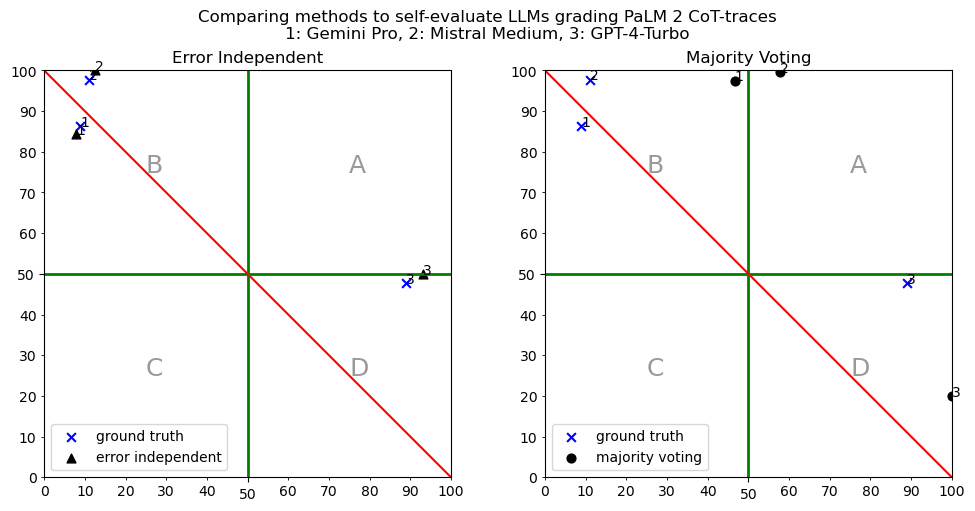

In [21]:
# We keep the closest solution at qa=217
nearest_logical_responses = ((17, 54), (27, 64), (202, 32))

size=40
qa = 217
qb = 281-qa
# We know to pick the 2nd solution as the one closest
# to ground truth
sol = 1
suptitle="Comparing methods to self-evaluate LLMs grading PaLM 2 CoT-traces\n1: Gemini Pro, 2: Mistral Medium, 3: GPT-4-Turbo"
compare_evaluations([
    ["ground truth", 
     [d['a']*100 for d in seval_exact["accuracy"]],
     [d['b']*100 for d in seval_exact["accuracy"]],
      "x","b",size],
    ["error independent",
     [raa/qa*100 for raa, rbb in nearest_logical_responses],
     [rbb/qb*100 for raa, rbb in nearest_logical_responses],
      "^", "k",size],
    ["majority voting",
     [d['a']*100 for d in mv_eval_exact[0]["accuracy"]],
     [d['b']*100 for d in mv_eval_exact[0]["accuracy"]],
      "o", "k",size],],0,
    titles=["Ground Truth","Error Independent", "Majority Voting"],
    figsize=(10,5),legend_loc="lower left",withArrows=False, suptitle=suptitle)

From the point of view of AI safety majority voting is making an egregious mistake with the evaluation of the 2nd LLM here - Mistral Medium. It thinks, incorrectly, that it is above 50% on both labels. Note that that the error-independent solution (corrected by projecting to the nearest logical one) does a much better job of telling us that all three LLMs are doing badly (worse than random) on one label or the other.